# Task - Clock glitching

## Password Bypass
<a id='another_cell'></a>

Passwords are in common use and nowadays users are forced to type in strong passwords for authentication, e.g. by using a combination of numbers, lower case letters, upper case letters and a minimum number of characters in total.<br>
Bruteforcing is harder with strong passwords but not always necessary as we will see in this section. <br>
Before we bypass the password check using glitching, take a look at the following C-Code of a password authentication function:

```C
#define PW_MAX_LEN 40
#define BUFF_SIZE  1024

/*
 * Authenticate user given a password
 */
int iAuthenticateUser(char * password) {
    int AuthFlag = 0;

    // Buffer where the password will be stored in 
    char cPasswordBuffer[PW_MAX_LEN];

    // Copy Password to buffer
    strcpy(cPasswordBuffer, password);

    // Compare with the stored (strong) password 
    if(strcmp(cPasswordBuffer, "D0N0tU53Un54f35tr1ngFunct10n5!") == 0) {
        // Password matches
        printf("passwords match\n");
        AuthFlag = 0x01;
    }
    return AuthFlag;
}

int main() {

        // Get password from user
        char data_buf[BUFF_SIZE];
        memset(data_buf, 0, BUFF_SIZE);
        printf("To get access to the device a password is required \n");
    
        // Reads in data from user
        read(0, data_buf, BUFF_SIZE);

        // Check if user is authenticated
        if(iAuthenticateUser(data_buf)== 0) {
                // Password was wrong - return
                return(0);
        }

        // Password matched
        printf("Access granted \n");
    
        /*
            Device does Security/Safety critical work or sends back sensible information
        */
        ...;
        ...;
        ...;

        return(0);
}
```

There are lots of examples like this, which show the importance of secure coding.

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">Can you imagine what could go wrong here?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

Wenn man die If-Anweisung, in der gecheckt wird, ob das Password stimmt, überspringen kann, ist der Code immer noch funktional. Aber man der Schutz ist nicht mehr aktiv

### BONUS QUESTION

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">Do you know by chance a method on how to find faults like these in software effectively?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

Fortunately, most password functions are better coded than the one shown above.
In the next sections you will learn about a fault injection method, which is, at last, able to bypass a secure version of the function above.

## Introduction to clock glitching

Microcontrollers execute instructions one after the other. The execution times are fixed with the clock signal. A single instruction may require multiple clock cycles, in which the instruction is fetched from memory and executed.<br>
To speed up the execution of several instruction the microcontroller uses the concept of a pipeline.
For the given Microcontroller STM32 F303 with a Cortex-M4 Core, the pipeline consists of three stages: fetch, decode, execute.<br>
If both of the next instructions are only 16 bit long, which is the case most of the times, both instructions are fetched simultaniously, while decoding and execution are done in sequence, as shown in the diagram.

![](images/pipelining.png)

At time t$_\text{3}$ instruction 1 is decoded and its execution is started, while instruction 2 has been fetched and starts decoding and instruction 3 and 4 are both fetched in parallel. This means that a single clock cycle is simultaniously used for different stages (fetch, decode, execute) for different instructions as illustrated above.<br>
The different stages may require a different amount of time to complete. With the manipulation of a single clock cycle multiple stages of the pipeline may be affected in different ways. According to this research (https://online.tugraz.at/tug_online/voe_main2.getvolltext?pCurrPk=79126) the stage decoding is not affected by the glitching, but the stages fetch and execute may both be affected. Glitching may lead to effectively skipping an instruction or the abort of the stage leading to a false result.

![](images/glitched_pipelining.png)

As shown above, the third clock period may be manipulated by pulling the clock line down for a short period of time between t$_\text{3}$ and t$_\text{3*}$ effectively introducint a new clock cycle. This results in the clock starting at t$_\text{3}$ being significantly shortened, which may result in the execution of instruction 1 being aborted, since the next rising edge at t$_\text{3*}$ forces the execution of instruction 2 and instructions 3 and 4 being unsuccessfully fetched, while instruction 2 remains unaffected.<br>
This behaviour is not defined by the manufacturer of the microcontroller and must be discovered by trial and error, as you will see in this task.<br>
Knowing about this behaviour lets you exploit it for example to bypass a password check. The behaviour is quite delicate though and may result in a lot of crashes of the microcontroller along the way.

With the hardware embedded into the ChipWhisperer it is possible to control the timings of the clock signal with a very high precision.<br>
The ChipWhisperer uses two configurable phase shifted clock signals and a few gates to create a glitch signal that can be applied to the clock signal using an XOR gate to briefly invert the target's clock signal.<br>
The following description is partially taken directly from the ChipWhisperer documentation:

A system clock (which can come from either the ChipWhisperer or the Device Under Test (DUT)) is used to generate the glitches. These glitches are then inserted back into the clock signal, although it's possible to use the glitches alone for other purposes (i.e. for voltage glitching, EM glitching).

The generation of glitches is done with two variable phase shift modules, configured as follows:

![glitch_phaseshift](images/Glitchgen-phaseshift.png)

The glitch enable line is used to determine when glitches are inserted. Glitches can be inserted continuously (useful for development) or triggered by some event. The following figure shows how the glitch can be muxed to output to the Device Under Test (DUT).

![glitch_phaseshift](images/Glitchgen-mux_small.png)

The clock glitching hardware in the ChipWhisperer can be adjusted theoretically in 30 ps increments. This allows for very precise adjustments. However, the adjustment range is with only $\pm$ 5 ns very short. For this task, the clock of the microcontroller is set to 7.37 MHz, which leads to a clock period of 136 ns. Ideally it should be possible to get an adjustment range of half a clock cycle, around $\pm$ 68 ns.<br>
This can be achieved by a partial reconfiguration of the underlying FPGA. All of this is done for you by the ChipWhisperer framework.

The phase shift is defined in percent with a range of $\pm$ 50 % for both the glitch offset and glitch width. For the glitch width, however, only a positive value makes sense.

![glitch_parameters](images/glitch_parameters.png)

The image above visualizes the glitch parameter ranges and shows an example glitch applied to the clock signal with a glitch offset of -30 % and a glitch width of 20 %.

Read trough the lecture slides of chapter 3_3. (https://gitlab.tf.uni-freiburg.de/embex-security-lab/security-lab-2022/-/blob/main/documentation/Lecture%20Slides/03_3-fault_injection.pdf)

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">To which attack class would you categorize clock glitching?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

Clockgliching zählt zu den non-inversive Attacken, da der chip in der Regel nicht beschädigt wird und nach nem reset wieder wie gewohnt funktioniert.
Falls der Chip eine eigene Clock besitzt, kann es sein, dass man doch an den chip muss und die Clock zu unterbinden oder mit der Datenlinie verbinden.
</font>

## Getting started with clock glitching

In the first part of this exercise you will get some experience with clock glitching using the ChipWhisperer. You will experimentally find suitable glitching parameters.<br>

ChipWhisperer comes with some helper scripts to get started and to interface with the ChipWhisperer board.

For your convenience they are located in the subfolder `helper_scripts/`.

Please plug in the ChipWhisperer with the provided USB cable and run the next cell.

Running the script `helper_scripts/Setup_Generic.ipynb` should result in the output:<br>

Serial baud rate = 38400<br>
INFO: Found ChipWhisperer😍

In [1]:
# settings for generic setup
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

# run the setup script
%run "helper_scripts/Setup_Generic.ipynb"

(ChipWhisperer NAEUSB WARNING|File naeusb.py:699) Your firmware (0.30) is outdated - latest is 0.62See https://chipwhisperer.readthedocs.io/en/latest/firmware.html for more information


INFO: Found ChipWhisperer😍


Brilliant! The connection to the ChipWhisperer board is now established.<br>
A custom firmware for the target chip is required for this task.<br>

The next cell flashes the provided `glitch.hex` file to the target chip.

In [2]:
# flash the target firmware to the ChipWhisperer STM32 chip
target_firmware = "glitch.hex"
cw.program_target(scope, prog, target_firmware)

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5463 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5463 bytes


The general configuration options for clock glitching have been described above. In the following section you will see how the configuration of the glitch module of the ChipWhisperer can be put into practice.

All the settings/methods for the glitch module can be accessed under `scope.glitch`

In [3]:
scope.glitch

clk_src     = target
width       = 10.15625
width_fine  = 0
offset      = 10.15625
offset_fine = 0
trigger_src = manual
arm_timing  = after_scope
ext_offset  = 0
repeat      = 1
output      = clock_xor

Some of the important settings we will want to look at here are:

* clk_src
> The clock signal that the glitch DCM is using as input. Can be set to "target" or "clkgen".<br>
In this case, we'll be providing the clock to the target, so we'll want this set to "clkgen"
* offset
> Where in the output clock to place the glitch. Can be in the range `[-50, 50]`.<br>
Often, we'll want to try many offsets when trying to glitch a target.
* width
> How wide to make the glitch. Can be in the range `[-50, 50]`, though there is no reason to use widths < 0. Wider glitches more easily cause glitches, but are also more likely to crash the target, meaning we'll often want to try a range of widths when attacking a target.
* output
> The output produced by the glitch module. For clock glitching, clock_xor is often the most useful option.
* ext_offset
> The number of clock cycles after the trigger to put the glitch. 
* repeat
> The number of clock cycles to repeat the glitch for. Higher values increase the number of instructions that can be glitched, but often increase the risk of crashing the target.
* trigger_src
> How to trigger the glitch. For this tutorial, we want to automatically trigger the glitch from the trigger pin only after arming the ChipWhipserer, so we'll use `ext_single`

For further information regarding the settings of the glitch module please refer to: https://chipwhisperer.readthedocs.io/en/latest/api.html#chipwhisperer.scopes.OpenADC.glitch

In addition, we'll need to tell ChipWhipserer to use the glitch module's output as a clock source for the target by setting `scope.io.hs2 = "glitch"`.<br>
Finally, we'll also use a `namedtuple` to make looping through parameters simpler.

The ChipWhisperer provides a glitch controller, to make the usage of the glitch module simpler to interface with. It is initialized with the different potential outcomes (e.g. `"success", "reset", "normal"`) and the different parameters (e.g. `"width", "offset"`) used for the glitch configuration.

In [4]:
import chipwhisperer.common.results.glitch as glitch
gc = glitch.GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset"])
gc.display_stats()

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='width setting:', disabled=True, max=10.0, readout…

FloatSlider(value=0.0, continuous_update=False, description='offset setting:', disabled=True, max=10.0, readou…

The glitch controller has a lot of functionality built in such as easily accessing the current settings. Those are updated in real time while glitching. This allows monitoring in real time the currently executed glitch configuration. This is especially helpfu to see the progress of the glitch attack, when the configuration space is rather large.

The glitch controller allows systematic generation of glitch settings in the glitch configuration space.

In [5]:
import time

# setting the ranges for the glitch offset and glitch width
gc.set_range("offset", -5, 5)
gc.set_range("width", 0, 5)

# each setting moves from min to max based in the global step size
gc.set_global_step([2.5])

# generate the set of glitch settings
for glitch_setting in gc.glitch_values():
    # print the generated settings
    print("Offset: {}\tWidth: {}".format(glitch_setting[1], glitch_setting[0]))
    time.sleep(.25)

Offset: -5	Width: 0
Offset: -2.5	Width: 0
Offset: 0.0	Width: 0
Offset: 2.5	Width: 0
Offset: 5.0	Width: 0
Offset: -5	Width: 2.5
Offset: -2.5	Width: 2.5
Offset: 0.0	Width: 2.5
Offset: 2.5	Width: 2.5
Offset: 5.0	Width: 2.5
Offset: -5	Width: 5.0
Offset: -2.5	Width: 5.0
Offset: 0.0	Width: 5.0
Offset: 2.5	Width: 5.0
Offset: 5.0	Width: 5.0


You can see that the settings are generated systematically by iterating over both glitch parameters.<br>
You can also see that the displayed statistics with `gc.display_stats()` are updated for every new set of glitch settings.

There are two more important configuration parameters:
- External offset `ext_offset`: the number of clock periods after the trigger after which the glitch shall be applied
- Affected consecutive clock periods `repeat`: the number of censecutive glitched clock periods.

As with a lot of security related tasks, visualization is very important to find patterns in data that can be used as an advantage. Glitching is no exception.<br>
In order to keep track of the most promising glitch configurations the results may be plotted in a two dimensional grid.

<IPython.core.display.Javascript object>


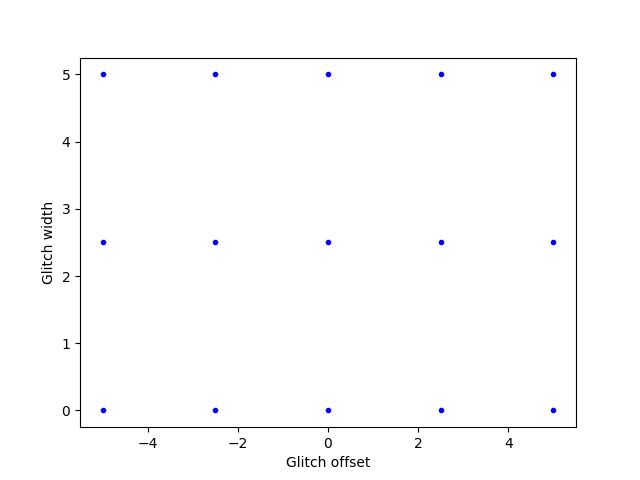

In [6]:
%matplotlib notebook
import matplotlib.pylab as plt
fig = plt.figure()

plt.xlabel("Glitch offset")
plt.ylabel("Glitch width")

for glitch_setting in gc.glitch_values():
    plt.plot(glitch_setting[1], glitch_setting[0], 'b.')

## to update the plot:
fig.canvas.draw()

This two dimensional representation will become very useful later on.

The target will crash a lot while glitching. The following function will help to reset the target.

In [7]:
 def reboot_flush():            
    scope.io.nrst = False
    time.sleep(0.05)
    scope.io.nrst = "high_z"
    time.sleep(0.05)
    #Flush garbage too
    target.flush()

## Nested loops

In this section a nested loop is attacked in order to get an idea about the glitching behaviour. The execution is triggered by sending a simpleserial message to the target board.

The following code snippet shows you the function executed while the glitching attempts are performed.<br>
We use a Trigger-pin to signal the ChipWhisperer when to start glitching. <br>
This is done for simplification since otherwise it can get quite challenging to configure the right spot to glitch.<br> 
Additionally we know that the Microcontroller crashed while glitching when the trigger is up before we send data to the target board.

```C
uint8_t glitch_loop(uint8_t* in) {
    volatile uint16_t i, j;
    volatile uint32_t cnt;
    cnt = 0;
    trigger_high(); // Set pin to high to signal the ChipWhisperer to begin glitching
    
    for(i=0; i<50; i++) {
        for(j=0; j<50; j++) {
            cnt++;
        }
    }
    
    trigger_low(); // Set pin to low
    simpleserial_put('r', 4, (uint8_t*)&cnt);  // Sends cnt back to CW via the simpleserial protocol (https://wiki.newae.com/SimpleSerial)
    return (cnt != 2500);
}
```

The microcontroller spends a lot of time in the nested loops especially in the branching instructions of the for loops, which makes the glitching easier. It is also really easy to see the effect of the glitch by monitoring the result count, which should be 2500 but will reduce in value if a glitch has been successful.

Let's check first that the correct firmware is being executed on the target. The result should be 2500.

In [8]:
import struct

# trigger the execution of the function glitch_loop
target.simpleserial_write("g", bytearray([]))

# request the response for the last request
response = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10)

print("Response count: {}".format(struct.unpack("<I", response['payload'])[0]))

Response count: 2500


Let's have a look at the result package received. There is a bit to unpack here.

In [9]:
print(response)
print(struct.unpack("<I", response['payload']))

{'valid': True, 'payload': bytearray(b'\xc4\t\x00\x00'), 'full_response': 'rC4090000\n', 'rv': 0}
(2500,)


- The field `'valid'` shows if the serial communication was valid.
- The field `'payload'` contains a bytearray with tuple wrapped up in a struct.
- The field `'full_response'` contains the payload as raw serial.
- The field `'rv'` shows the return value / error code.

The unpacked tuple contains a single value, which corresponds to the returned count value by the nested loops.

Let's start glitching.

A general configuration of the glitch controller has to be performed as you can see in the next cell.

In [10]:
#Basic setup for the glitch controller
scope.glitch.clk_src = "clkgen" # set glitch input clock
scope.glitch.output = "clock_xor" # glitch_out = clk XOR glitch
#Trigger will be set from victim software 
scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called. 

scope.io.hs2 = "glitch"  # output glitch_out on the clock line
print(scope.glitch)

clk_src     = clkgen
width       = 10.15625
width_fine  = 0
offset      = 10.15625
offset_fine = 0
trigger_src = ext_single
arm_timing  = after_scope
ext_offset  = 0
repeat      = 1
output      = clock_xor



In [11]:
gc.display_stats()

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='width setting:', disabled=True, max=5.0, readout_…

FloatSlider(value=-5.0, continuous_update=False, description='offset setting:', disabled=True, max=5.0, min=-5…

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">What do you expect from the following glitch loop?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
Die returnvalue sollte kleiner als 2500 sien da durch den glich einzele loopdurchläufe übersprungen werden.
</font>

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">How will a successful glitch alter the return value of the function?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
Mann kan anhand der diverenz von 2500 und dem retunwert erkennen, wie viele gliches erfolgreich sind/waren.<br>
generell sollte der Wert von 2500 abweichen
</font>

Please complete the following glitch loop.
You will need the knowledge about the effect of a successful glitch, to identify a successful glitch in the glitch loop.

You will see that the execution will take some time, as the loop iterates over the different glitch configuration settings.

In [12]:
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import trange
import struct

# set external offset
scope.glitch.ext_offset = 2
gc.set_range("width", 0, 49)
gc.set_range("offset", -49, 49)
gc.set_global_step([2])
scope.glitch.repeat = 3

scope.adc.timeout = 0.1

reboot_flush()

# iterate over all glitch settings
##
for glitch_setting in gc.glitch_values():
    
    # raise NotImplementedError("Add your code here, and delete this.")
    scope.glitch.offset = glitch_setting[1]
    scope.glitch.width = glitch_setting[0]
    # speed up, if the trigger has never been low without waiting for timeout
    if scope.adc.state:
        # can detect crash here (fast) before timing out (slow)
        print("Trigger still high!")
        gc.add("reset", (scope.glitch.width, scope.glitch.offset))
        
        reboot_flush()
        
    # The glitching is only possible when armed.
    scope.arm()
    
    # send message
    target.simpleserial_write("g", bytearray([]))
    ##
    ret = scope.capture()
    
    # get return message
    response = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10)
    ##
    
    # check if target has crashed
    if ret:
        # timeout
        gc.add("reset", (scope.glitch.width, scope.glitch.offset))
    else:
        # response message received
        # raise NotImplementedError("Add your code here, and delete this.")
        if response['valid'] is False:# ignore invalid messages
            continue
        else:
            # get glitch_count from response message and check if it is normal
            glitch_count = struct.unpack("<I", response['payload'])
            #print(glitch_count[0])
            
            # raise NotImplementedError("Add your code here, and delete this.")
            if glitch_count[0] == 2500:
                 gc.add("normal", (scope.glitch.width, scope.glitch.offset))
            else: # glitch successful :)
                gc.add("success", (scope.glitch.width, scope.glitch.offset))

(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfigurati

(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration for width = 0 may not work
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:765) Partial reconfiguration f

Trigger still high!


(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!


Trigger still high!


(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!


Trigger still high!


(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative offsets <-45 may result in double glitches!
(ChipWhisperer Glitch WARNING|File ChipWhispererGlitch.py:940) Negative 

Next: visualize the glitch settings in a two dimensional view.

<IPython.core.display.Javascript object>


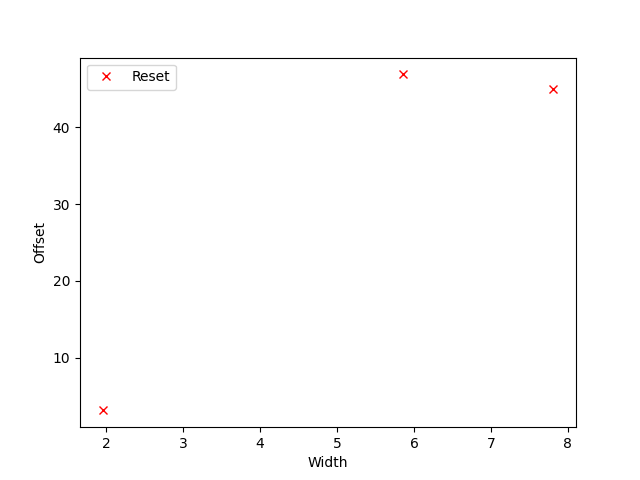

In [13]:
%matplotlib notebook
gc.results.plot_2d(plotdots={"success":"+g", "reset":"xr", "normal": None})

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">What do you notice in the diagram, is there a certain area you would like to have a closer look at?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">Do you think the pattern for successful glitches will differ for:<br>
a) Same Microcontroller running a different software?<br>
b) Different Microcontroller running the same software?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

Play around with the settings and ranges. With reducing the global_step size you will gain a much higher "resolution" at the cost of execution time. It makes sense to first explore the space of glitch settings and dive deeper once you found sub-spaces worth taking a closer look at.<br>

Adjust the glitch settings in such a way that it guarantees you a successfull glitch.<br>
You can also try a range of settings, the success rate should then be higher than 90%.

In [ ]:
# Play around with the settings
# Have a look at gc.display_stats() to see in real time which set of settings are tried at the time.

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">What are the most promising glitch settings with a success rate of at least 90%?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

Remember the glitch settings you find most promising because these settings will come in useful in the following glitch attempts.<br>
In practise, these kind of attacks take quite some time to find a successfull glitch.<br>
After finding one you want to use the information on where to find the glitch, to reproduce it.<br>

In [ ]:
raise NotImplementedError("Add your code here, and delete this.")

## Bypass password check using Fault Injection

Take a look at another password authentication function:

```C
uint8_t password(uint8_t* pw)
{
    char passok = 1;
    int cnt;

    trigger_high();

    //Simple test - doesn't check for too-long password!
    for(cnt = 0; cnt < PW_LEN; cnt++){
        if (pw[cnt] != passwd[cnt]){
            passok = 0;
        }
    }
    
    ..
    ..
    ..
    ..

}
```

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">How was the flaw from the function in 3.1 fixed?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

For the following task a similar function is implemented to check the password.

Assuming the password is complex enough, bruteforcing it will be impractical. <br> 
Fortunately, you already lernead a bit about clock glitching and we might be able to utilize this knowledge to bypass the password even for a simingly secure function like this!<br>

But first we need to flash the software onto our target.

In [ ]:
# flash the target firmware to the ChipWhisperer STM32 chip
target_firmware = "PasswordBypass.hex"
cw.program_target(scope, prog, target_firmware)

We don't know a lot about the password check and authentication function we want to bypass.<br>
The system requires the transmission of the password via serial communication.<br>
We can send a dummy password with a length of 6 to get started ...

In [ ]:
# send dummy password
pw = bytearray([0x00]*6)
target.simpleserial_write('p', pw)

val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    raw_serial = val['full_response']
    error_code = val['rv']

print(val)

... and get a response that the request was invalid.<br>

Send passwords with different lengths and see if you can get the system to accept the request (not necessarily the password) as valid.

In [ ]:
for pw_len in range(30):
    raise NotImplementedError("Add your code here, and delete this.")

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">What is the correct length of the password and how did you find it?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

Once we got the correct password length the actual code as shown below is executed and glitching it should enable us to bypass the password check alltogether.

```C
if (passok == 1) {
    //Simple test - doesn't check for too-long password!
    for(cnt = 0; cnt < PW_LEN; cnt++){
        if (pw[cnt] != passwd[cnt]){
            passok = 0;
        }
    }
}
```

We keep the glitch setup from the previous section (Nested loops) but want to add a parameter for external offset `ext_offset` to shift the glitched clock to match the time of execution of the code above.

In [ ]:
# Add the external offset "ext_offset" to the parameters 
# gc = glitch.GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset"])
# gc.display_stats()
gc = glitch.GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset", "ext_offset"])
gc.display_stats()

Let's print the generated glitch settings with our new parameter.

In [ ]:
# setting the ranges for the glitch offset and glitch width
gc.set_range("width", 13, 13)
gc.set_range("offset", -2.5, -2.5)
gc.set_range("ext_offset", 0, 20)


# each setting moves from min to max based on the global step size
gc.set_global_step([1])

# generate the set of glitch settings
for glitch_setting in gc.glitch_values():
    # print the generated settings
    print("Offset: {}\tWidth: {}\tExt Offset: {}".format(glitch_setting[1], glitch_setting[0], glitch_setting[2]))
    time.sleep(.1)

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">How can you check the success of your glitch attack?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

We provide you with a template to glitch the abovementioned password authentication function.
Take the previous steps into consideration to get successful glitches. 

In [ ]:
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import trange
import struct

# set external offset
gc.set_range("width", 0, 50)
gc.set_range("offset", -50, 50)
gc.set_range("ext_offset", 0, 20)
gc.set_global_step([0.5])

scope.glitch.repeat = 3

scope.adc.timeout = 0.1

reboot_flush()
# iterate over all glitch settings
for glitch_setting in gc.glitch_values(): ##
    scope.glitch.offset = 
    scope.glitch.width = 
    scope.glitch.ext_offset = 
 
    # speed up, if the trigger has never been low without waiting for timeout
    if scope.adc.state:
        # can detect crash here (fast) before timing out (slow)
        print("Trigger still high!")
        gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
        
        reboot_flush()
        
    # The glitching is only possible when armed.
    scope.arm()
    
    # send message
    
    ret = scope.capture()
    
    # get return message
    
    # check if target has crashed
    if ret:
        # timeout
        gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
        reboot_flush() ##
    else:
        # response message received
        if val['payload'] is None: ## ignore invalid messages
            continue 
        
        else:
            # password check ok?
            if :
                gc.add("success", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
            else:
                gc.add("normal", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">What is your decider to determine the success of a glitch attempt?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">Considering the authentication function source code, where do you think (instruction or part of instruction) the glitch happened and why?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

## Password Bypass using Power Analysis and Fault Injection

In the previously used implementation, the firmware sent back information if the password was correct or not.<br>
This is a major (and unfortunately quite common) security flaw, which allows automization of a lot of attacks. <br> 
In this task we will use a more secure version of the password authentication function. <br> 
The same protocol was used but we will not gain any information. <br> 
This task will give you more freedom than the previous ones. Try to use code / knowledge from the DPA and glitching tasks.

Like always, flash the firmware on the target first.

In [ ]:
# flash the target firmware to the ChipWhisperer STM32 chip
target_firmware = "PasswordBypassTask_3_6.hex"
cw.program_target(scope, prog, target_firmware)

As in 3.5 let's first find out the length of the password. <br>
This approach will be more realistic but is a bit tricky. <br> 
Send passwords with the different lengths to the device as before. 
Try to use a simple power analysis to find out which of the password lenghts you tried was the correct one.<br>
Differently to the previous tasks, there is no trigger implemented in the firmware of the Microcontroller to tell the ChipWhisperer when to begin recording the power trace, so you should find a fitting trigger and try to fit the window where the sampling is done. <br>
You might want to look at the following commands in the documentation:<br>
https://chipwhisperer.readthedocs.io/en/latest/api.html#chipwhisperer.scopes.OpenADC.adc <br>
https://chipwhisperer.readthedocs.io/en/latest/api.html#chipwhisperer.scopes.OpenADC.trigger <br>
https://chipwhisperer.readthedocs.io/en/latest/api.html#chipwhisperer.scopes.OpenADC.clock

<font color="darkgreen">
<details>
<summary>
<div>
<img src="images/hint_darkgreen.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em">
<b>Click to show hints</b>
</span>
</div>
</summary>

Keep in mind you will have to send the password first.<br>
Is there a way to get your trigger timed by the transmitted password?

</details></font>

In [ ]:
from tqdm import tnrange
import numpy as np

trace_array = []
N = 

# adjust trigger and adc settings 

# Loop over pw lenghts
for i in tnrange(N, desc='Capturing traces'):
    
    # flush before getting the traces
    reboot_flush()
    
    # setup power analysis and send password 
    
    ret = 
    
    if ret:
        print("Target timed out!")
        continue
        
    # store captured trace

# Plot the different traces 
    

What is your guess for the password length and why?<br>
`--- please fill in with your own observations ---`<br>

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">What is your guess for the password length and why?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

In the next step we want to glitch this target. 
In order to find out if we glitched successfully, you should use the power traces. 
To make it easier, we recorded a trace of a successful password authentication, this was done on a different device, where the password is known.

![](images/Trace_Successful_Pw.png)

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">Comparing the prerecorded trace with the trace you recorded, what differences do you see?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">How could you use the differences of the two power traces to sort the successful and unsuccessful glitches?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

You can do the next task in two ways. One is much harder than the other. <br>
- First option: You use the same firmware as before but with the internal triggers added in.<br> 
With this added internal trigger you can glitch as in 3.5 but using the power traces as a metric to decide if the glitch was a success or not. <br>
- Second option: The more realistic (but harder) approach would be to use the PasswordBypassTask_2_5.hex firmware and fit the glitches to the time, where in the trace, the sensitive password check is done. **Consider this as a bonus task and only do this if you feel comfortable with the ChipWhisperer and trigger settings.**<br>
Depending on which way you want to solve, execute the next block, or not.

In [ ]:
# flash the target firmware to the ChipWhisperer STM32 chip
target_firmware = "Task3.6_withTrigger.hex"
cw.program_target(scope, prog, target_firmware)

# set trigger to default parameters for internal trigger
scope.default_setup()
scope.glitch.clk_src = 'clkgen'
scope.glitch.trigger_src = 'ext_single'
scope.glitch.repeat = 1
scope.glitch.output = "clock_xor"
scope.io.hs2 = "glitch"

If you want to do the approach without using the software trigger, you need to use the ext_offset to hit the same spot when the internal trigger would go up, which is right before the password-checking loop.<br>
Now it's your turn to try it, good luck!

Don't forget to visualize your glitch results and there is always `gc.display_stats()` to keep track of the currently executed glitch attempt.

In [ ]:
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import trange
import struct

# settings
gc.set_range("width", 0, 50)
gc.set_range("offset", -50, 50)
gc.set_range("ext_offset", 0, 20) # you might want to change that if you decided to do the bonus task
gc.set_global_step([0.5])

scope.glitch.repeat = 3

scope.adc.timeout = 0.1

# put the recorded traces in a list to validate afterwards
pw_traces_success = []
pw_traces_normal = []

reboot_flush()

# iterate over all glitch settings
for glitch_setting in gc.glitch_values(): ##
    scope.glitch.offset = 
    scope.glitch.width = 
    scope.glitch.ext_offset = 
 
    # speed up, if the trigger has never been low without waiting for timeout
    if scope.adc.state:
        # can detect crash here (fast) before timing out (slow)
        print("Trigger still high!")
        gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
        reboot_flush()
        
    # The glitching is only possible when armed.
    scope.arm()
    
    # send message
    
    ret = scope.capture()
    
    # get power trace
    
    # check if target has crashed
    if ret:
        # timeout
        gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
    else:

        else:
            # Implement your metric to check the power trace
            if :
                gc.add("success", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
            else:
                gc.add("normal", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt
plt.figure() # Creates a new figure

#Check if they look right
for trace in pw_traces_success:
    plt.plot(abs(trace))
plt.show()

## Conclusion

As you have seen even without knowing anything about the key or the encryption used you were hopefully able to deduce enough information about the data to decrypt them anyways.

But why was this possible?<br>



### Exploited weaknesses

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>

<span style="line-height:24px; margin-left: 0.5em"><font color='darkblue'>List the weaknesses you have exploited throughout this task and explain why they lead to you decrypting the cipher text.</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

### Promising counter measures

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>

<span style="line-height:24px; margin-left: 0.5em"><font color='darkblue'>Can you think of one or more promising counter measure(s) that would have prevented your attack from being successful?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

### Challenges 

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>

<span style="line-height:24px; margin-left: 0.5em"><font color='darkblue'>List the challanges you faced and describe your train of thought that lead you to mastering them.</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

## Submission

Please commit your changes thus far until the end of the timeframe of this task according to:<br>
https://gitlab.tf.uni-freiburg.de/embex-security-lab/security-lab-2022

## Additional presentation task
**You only have to work on the following task if you decided to present for this task**<br>
You are welcome to continue working on the following task without presentation, if you have chosen a different task to present.

You will find an additional course provided by ChipWhisperer in their repository -> 'ChipWhisperer5_64\git\home\portable\chipwhisperer\jupyter\courses\fault101\Fault 2_1 - Introduction to Voltage Glitching.ipynb'. <br>
The course consists of the same loop as Task 3.4 but the Fault injection will be based on Voltage Glitching.<br> 
Finish the course and create a presentation with a few slides showing your approach and results from this task and show differences between the Fault Injection methods.<br>


You can find the date for the presentation here: https://gitlab.tf.uni-freiburg.de/embex-security-lab/security-lab-2022

*Acknowledgement: the material used in this task is inspired and partially taken from the ChipWhisperer learning material.*